In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import time
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
from collections import defaultdict
import gc
import matplotlib.pyplot as plt
import seaborn as sns

# Set your environment paths
# os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
# os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
# os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
os.environ['HF_DATASETS_CACHE'] = "D:/Python Projects/recommendation_system/recsys/data"
os.environ['TRANSFORMERS_CACHE'] = "D:/Python Projects/recommendation_system/recsys/models"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from tensorboardX import SummaryWriter

In [2]:
# Set random seeds for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Configuration
SOURCE_DOMAIN = "Movies_and_TV"
TARGET_DOMAIN = "Video_Games"
DOMAINS = [SOURCE_DOMAIN, TARGET_DOMAIN]

MIN_USER_INTERACTIONS = 10
MIN_ITEM_INTERACTIONS = 10
POSITIVE_THRESHOLD = 4.0

Using device: cuda


In [3]:
def load_amazon_reviews(domain: str, max_per_domain: int = 100000) -> pd.DataFrame:
    """Load Amazon reviews dataset"""
    dataset = load_dataset("McAuley-Lab/Amazon-Reviews-2023",
                           f"raw_review_{domain}",
                           trust_remote_code=True)
    rows = []
    for i, r in enumerate(dataset["full"]):
        if i >= max_per_domain:
            break
        rows.append({
            "user": r["user_id"],
            "item": r["parent_asin"],
            "rating": float(r["rating"]),
            "domain": domain,
            "verified_purchase": r["verified_purchase"],
            "timestamp": int(r["timestamp"])
        })

    return pd.DataFrame(rows)

In [4]:
class OptimizedRatingDataset(Dataset):
    """Optimized dataset that generates negative samples on-the-fly"""
    def __init__(self, df, negatives_dict, num_neg, is_training=True):
        super().__init__()
        self.df = df
        self.negatives_dict = negatives_dict
        self.num_neg = num_neg
        self.is_training = is_training
        self.users = df["user_id"].values
        self.items = df["item_id"].values
        self.ratings = df["rating"].values

    def __len__(self):
        if self.is_training:
            return len(self.df) * (1 + self.num_neg)
        return len(self.df)

    def __getitem__(self, idx):
        if self.is_training:
            # For training, generate positive and negative samples
            original_idx = idx // (1 + self.num_neg)
            sample_type = idx % (1 + self.num_neg)

            user = self.users[original_idx]

            if sample_type == 0:
                # Positive sample
                item = self.items[original_idx]
                rating = self.ratings[original_idx]
            else:
                # Negative sample
                neg_items = list(self.negatives_dict[user])
                item = random.choice(neg_items)
                rating = 0.0

            return (torch.tensor(user, dtype=torch.long),
                   torch.tensor(item, dtype=torch.long),
                   torch.tensor(rating, dtype=torch.float))
        else:
            # For validation/test, return as is
            return (torch.tensor(self.users[idx], dtype=torch.long),
                   torch.tensor(self.items[idx], dtype=torch.long),
                   torch.tensor(self.ratings[idx], dtype=torch.float))

class RatingDataset(Dataset):
    """Simple dataset for evaluation"""
    def __init__(self, user_list, item_list, rating_list):
        self.user_list = user_list
        self.item_list = item_list
        self.rating_list = rating_list

    def __len__(self):
        return len(self.user_list)

    def __getitem__(self, idx):
        return (torch.tensor(self.user_list[idx], dtype=torch.long),
                torch.tensor(self.item_list[idx], dtype=torch.long),
                torch.tensor(self.rating_list[idx], dtype=torch.float))

In [16]:
class OptimizedNCFData(object):
    def __init__(self, df, num_neg=4, num_neg_test=99, batch_size=1024):
        self.df = df
        self.num_neg = num_neg
        self.num_neg_test = num_neg_test
        self.batch_size = batch_size

        # Filter users and items with minimum interactions
        user_counts = df["user"].value_counts()
        item_counts = df["item"].value_counts()

        valid_users = user_counts[user_counts >= 5].index
        valid_items = item_counts[item_counts >= 5].index

        self.df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
        print(f"Filtered dataset: {len(self.df)} interactions, {self.df['user'].nunique()} users, {self.df['item'].nunique()} items")

        self.preprocess_df = self._reindex(self.df)
        self.user_pool = set(self.preprocess_df["user_id"].unique())
        self.item_pool = set(self.preprocess_df["item_id"].unique())

        self.train_df, self.val_df, self.test_df = self._leave_one_out(self.preprocess_df)
        self.negatives = self._negative_sampling(self.preprocess_df)

    def _reindex(self, df):
        """Reindex userID and itemID"""
        user_list = list(df["user"].drop_duplicates())
        user2id = {w: i for i, w in enumerate(user_list)}
        id2user = {i: w for w, i in user2id.items()}

        item_list = list(df["item"].drop_duplicates())
        item2id = {w: i for i, w in enumerate(item_list)}
        id2item = {i: w for w, i in item2id.items()}

        # Store the mappings as instance variables
        self.user2id = user2id
        self.id2user = id2user
        self.item2id = item2id
        self.id2item = id2item

        df["user_id"] = df["user"].apply(lambda x: user2id[x])
        df["item_id"] = df["item"].apply(lambda x: item2id[x])
        df["rating"] = df["rating"].apply(lambda x: float(x >= POSITIVE_THRESHOLD))

        self.n_users = len(user2id)
        self.n_items = len(item2id)

        return df

    def _leave_one_out(self, df):
        """Fixed leave-one-out split"""
        df["rank_latest"] = df.groupby(["user_id"])["timestamp"].rank(method="first", ascending=False)

        # Keep most recent for test, second most recent for validation
        test = df.loc[df["rank_latest"] == 1].copy()
        val = df.loc[df["rank_latest"] == 2].copy()
        train = df.loc[df["rank_latest"] > 2].copy()

        # Only keep users that appear in all three sets
        common_users = set(train["user_id"].unique()) & set(val["user_id"].unique()) & set(test["user_id"].unique())

        train = train[train["user_id"].isin(common_users)]
        val = val[val["user_id"].isin(common_users)]
        test = test[test["user_id"].isin(common_users)]

        print(f"Split sizes - Train: {len(train)}, Val: {len(val)}, Test: {len(test)}")
        print(f"Common users: {len(common_users)}")

        return (train[["user_id", "item_id", "rating"]],
                val[["user_id", "item_id", "rating"]],
                test[["user_id", "item_id", "rating"]])

    def _negative_sampling(self, df):
        """Create negative sampling dictionary"""
        interact_status = defaultdict(set)

        for _, row in df.iterrows():
            interact_status[row["user_id"]].add(row["item_id"])

        negatives_dict = {}
        for user_id in interact_status:
            negatives_dict[user_id] = self.item_pool - interact_status[user_id]

        self.user_interactions = interact_status  # Store for later use
        return negatives_dict

    def get_train_loader(self):
        """Get optimized training data loader"""
        dataset = OptimizedRatingDataset(
            self.train_df,
            self.negatives,
            self.num_neg,
            is_training=True
        )
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True, num_workers=0)

    def get_val_loader(self):
        """Get validation data loader for evaluation"""
        users, items, ratings = [], [], []

        for _, row in self.val_df.iterrows():
            user_id = row["user_id"]

            # Add positive sample
            users.append(user_id)
            items.append(row["item_id"])
            ratings.append(1.0)

            # Add negative samples
            neg_items = list(self.negatives[user_id])
            sampled_neg = random.sample(neg_items, min(self.num_neg_test, len(neg_items)))

            for neg_item in sampled_neg:
                users.append(user_id)
                items.append(neg_item)
                ratings.append(0.0)

        dataset = RatingDataset(users, items, ratings)
        return DataLoader(dataset, batch_size=self.num_neg_test + 1, shuffle=False)

    def get_test_loader(self):
        """Get test data loader for evaluation"""
        users, items, ratings = [], [], []

        for _, row in self.test_df.iterrows():
            user_id = row["user_id"]

            # Add positive sample
            users.append(user_id)
            items.append(row["item_id"])
            ratings.append(1.0)

            # Add negative samples
            neg_items = list(self.negatives[user_id])
            sampled_neg = random.sample(neg_items, min(self.num_neg_test, len(neg_items)))

            for neg_item in sampled_neg:
                users.append(user_id)
                items.append(neg_item)
                ratings.append(0.0)

        dataset = RatingDataset(users, items, ratings)
        return DataLoader(dataset, batch_size=self.num_neg_test + 1, shuffle=False)

In [6]:
class ImprovedMatrixFactorization(nn.Module):
    """Improved MF model with dropout and better initialization"""
    def __init__(self, n_users, n_items, embedding_dim, dropout=0.2):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        self.user_bias = nn.Embedding(n_users, 1)
        self.item_bias = nn.Embedding(n_items, 1)
        self.global_bias = nn.Parameter(torch.zeros(1))
        self.dropout = nn.Dropout(dropout)

        # Better initialization
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)
        nn.init.zeros_(self.user_bias.weight)
        nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.dropout(self.user_embedding(user_ids))
        item_embeds = self.dropout(self.item_embedding(item_ids))

        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        output = dot_product + self.user_bias(user_ids) + self.item_bias(item_ids) + self.global_bias

        return torch.sigmoid(output).squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embedding.num_embeddings).to(next(self.parameters()).device)

        user_embed = self.user_embedding(user_tensor)
        item_embeds = self.item_embedding(all_items)

        scores = torch.matmul(user_embed, item_embeds.T).squeeze()
        scores += self.user_bias(user_tensor).squeeze()
        scores += self.item_bias(all_items).squeeze()
        scores += self.global_bias

        return torch.sigmoid(scores)

In [7]:
def precision_at_k(actual, predicted, k):
    """Calculate Precision@K"""
    if len(predicted) > k:
        predicted = predicted[:k]

    return len(set(actual) & set(predicted)) / len(predicted) if len(predicted) > 0 else 0

def recall_at_k(actual, predicted, k):
    """Calculate Recall@K"""
    if len(predicted) > k:
        predicted = predicted[:k]

    return len(set(actual) & set(predicted)) / len(actual) if len(actual) > 0 else 0

def hit(ng_item, pred_items):
    """Calculate hit ratio"""
    return 1 if ng_item in pred_items else 0

def ndcg(ng_item, pred_items):
    """Calculate NDCG"""
    if ng_item in pred_items:
        index = pred_items.index(ng_item)
        return np.reciprocal(np.log2(index + 2))
    return 0

def comprehensive_metrics(model, test_loader, k_values, device):
    """Calculate comprehensive metrics including HR@K, NDCG@K, Precision@K, and Recall@K"""
    metrics_dict = {k: {"HR": [], "NDCG": [], "Precision": [], "Recall": []} for k in k_values}
    model.eval()

    with torch.no_grad():
        for user, item, label in test_loader:
            user = user.to(device)
            item = item.to(device)

            predictions = model(user, item)

            # Get positive item (first one in the batch)
            ng_item = item[0].item()

            for k in k_values:
                _, indices = torch.topk(predictions, min(k, len(predictions)))
                recommends = torch.take(item, indices).cpu().numpy().tolist()

                # HR@K and NDCG@K
                metrics_dict[k]["HR"].append(hit(ng_item, recommends))
                metrics_dict[k]["NDCG"].append(ndcg(ng_item, recommends))

                # Precision@K and Recall@K
                actual = [ng_item]  # In leave-one-out, we have one positive item
                metrics_dict[k]["Precision"].append(precision_at_k(actual, recommends, k))
                metrics_dict[k]["Recall"].append(recall_at_k(actual, recommends, k))

    # Calculate averages
    avg_metrics = {}
    for k in k_values:
        avg_metrics[k] = {
            "HR": np.mean(metrics_dict[k]["HR"]),
            "NDCG": np.mean(metrics_dict[k]["NDCG"]),
            "Precision": np.mean(metrics_dict[k]["Precision"]),
            "Recall": np.mean(metrics_dict[k]["Recall"])
        }

    return avg_metrics

In [8]:
def get_recommendations(model, user_id, data, top_k=10, exclude_interacted=True):
    """Get top-k recommendations for a user"""
    model.eval()

    with torch.no_grad():
        scores = model.predict_all_items(user_id)

        if exclude_interacted and user_id in data.user_interactions:
            # Set scores of already interacted items to -inf
            interacted_items = data.user_interactions[user_id]
            for item_id in interacted_items:
                scores[item_id] = -float("inf")

        # Get top-k items
        top_scores, top_indices = torch.topk(scores, top_k)

        recommendations = []
        for idx, score in zip(top_indices.cpu().numpy(), top_scores.cpu().numpy()):
            original_item = data.id2item[idx]
            recommendations.append({
                "item_id": idx,
                "item": original_item,
                "score": float(score)
            })

    return recommendations

In [9]:
def plot_training_history(train_losses, val_losses, val_metrics, save_path="training_history.png"):
    """Plot training history including train/val loss and metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle("Training History", fontsize=16)

    # Plot training and validation loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].plot(val_losses, label="Validation Loss", color="red")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training vs Validation Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@10
    hr_values = [m["HR"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label="Val HR@10", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("HR@10")
    axes[0, 1].set_title("Validation Hit Rate@10")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@10
    ndcg_values = [m["NDCG"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label="Val NDCG@10", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel("NDCG@10")
    axes[0, 2].set_title("Validation NDCG@10")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@10
    precision_values = [m["Precision"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label="Val Precision@10", color="purple", marker='^')
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Precision@10")
    axes[1, 0].set_title("Validation Precision@10")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@10
    recall_values = [m["Recall"] for m in val_metrics]
    axes[1, 1].plot(recall_values, label="Val Recall@10", color="brown", marker="v")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Recall@10")
    axes[1, 1].set_title("Validation Recall@10")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label="HR@10", marker="o")
    axes[1, 2].plot(ndcg_values, label="NDCG@10", marker="s")
    axes[1, 2].plot(precision_values, label="Precision@10", marker="^")
    axes[1, 2].plot(recall_values, label="Recall@10", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

In [10]:
def plot_metrics_comparison(metrics_dict, save_path="metrics_comparison.png"):
    """Plot comparison of different metrics at various K values"""
    k_values = list(metrics_dict.keys())
    metric_names = ["HR", "NDCG", "Precision", "Recall"]

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle("Metrics Comparison at Different K Values", fontsize=16)

    for idx, metric in enumerate(metric_names):
        ax = axes[idx // 2, idx % 2]
        values = [metrics_dict[k][metric] for k in k_values]

        bars = ax.bar(range(len(k_values)), values, color=plt.cm.viridis(np.linspace(0.3, 0.9, len(k_values))))
        ax.set_xlabel("K")
        ax.set_ylabel(metric)
        ax.set_title(f"{metric} at Different K Values")
        ax.set_xticks(range(len(k_values)))
        ax.set_xticklabels([f'K={k}' for k in k_values])

        # Add value labels on bars
        for bar, value in zip(bars, values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f"{value:.4f}', ha='center', va='bottom")

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

In [11]:
def calculate_loss(model, data_loader, device):
    """Calculate average loss for a dataset"""
    model.eval()
    loss_fn = nn.BCELoss()
    total_loss = 0
    batch_count = 0

    with torch.no_grad():
        for user, item, label in data_loader:
            user = user.to(device)
            item = item.to(device)
            label = label.to(device)

            predictions = model(user, item)
            loss = loss_fn(predictions, label)

            total_loss += loss.item()
            batch_count += 1

    return total_loss / batch_count if batch_count > 0 else 0


In [12]:
def train_model_with_metrics(model, train_loader, val_loader, epochs, device, learning_rate=0.001, weight_decay=1e-5):
    """Enhanced training loop with comprehensive metrics tracking on validation set"""
    loss_fn = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="max", patience=3, factor=0.5)

    writer = SummaryWriter()
    best_hr = 0

    train_losses = []
    val_losses = []
    val_metrics = []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        batch_count = 0

        start_time = time.time()

        # Training with progress bar
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for batch_idx, (user, item, label) in enumerate(pbar):
                user = user.to(device)
                item = item.to(device)
                label = label.to(device)

                optimizer.zero_grad()
                predictions = model(user, item)
                loss = loss_fn(predictions, label)
                loss.backward()
                optimizer.step()

                total_loss += loss.item()
                batch_count += 1

                # Update progress bar
                pbar.set_postfix({"loss": loss.item()})

        # Calculate average training loss for the epoch
        avg_train_loss = total_loss / batch_count
        train_losses.append(avg_train_loss)

        # Calculate validation loss
        avg_val_loss = calculate_loss(model, val_loader, device)
        val_losses.append(avg_val_loss)

        # Comprehensive evaluation on VALIDATION set
        model.eval()
        metrics = comprehensive_metrics(model, val_loader, [10], device)
        val_metrics.append(metrics[10])

        hr = metrics[10]["HR"]
        ndcg = metrics[10]["NDCG"]
        precision = metrics[10]["Precision"]
        recall = metrics[10]["Recall"]

        # Learning rate scheduling based on validation HR
        scheduler.step(hr)

        # Logging to TensorBoard
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)
        writer.add_scalar("Loss/Validation", avg_val_loss, epoch)
        writer.add_scalar("Metrics/Val_HR@10", hr, epoch)
        writer.add_scalar("Metrics/Val_NDCG@10", ndcg, epoch)
        writer.add_scalar("Metrics/Val_Precision@10", precision, epoch)
        writer.add_scalar("Metrics/Val_Recall@10", recall, epoch)
        writer.add_scalar("Learning_Rate", optimizer.param_groups[0]['lr'], epoch)

        elapsed_time = time.time() - start_time

        print(f"Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, "
              f"Val HR@10={hr:.4f}, Val NDCG@10={ndcg:.4f}, "
              f"Val Prec@10={precision:.4f}, Val Rec@10={recall:.4f}, "
              f"Time={elapsed_time:.2f}s, LR={optimizer.param_groups[0]['lr']:.6f}")

        # Save best model based on validation HR
        if hr > best_hr:
            best_hr = hr
            torch.save(model.state_dict(), 'best_model.pth')
            print(f"  --> New best model saved with Val HR@10={hr:.4f}")

    writer.close()
    return train_losses, val_losses, val_metrics, best_hr

In [13]:
def final_evaluation(model, test_loader, device):
    """Perform final evaluation on test set with multiple K values"""
    print("\n" + "="*50)
    print("FINAL EVALUATION ON TEST SET")
    print("="*50)

    k_values = [5, 10, 20, 50]
    metrics = comprehensive_metrics(model, test_loader, k_values, device)

    # Create a nice table for results
    print("\nMetrics Results:")
    print("-" * 60)
    print(f"{'K':<5} {'HR':<10} {'NDCG':<10} {'Precision':<12} {'Recall':<10}")
    print("-" * 60)

    for k in k_values:
        print(f"{k:<5} {metrics[k]['HR']:<10.4f} {metrics[k]['NDCG']:<10.4f} "
              f"{metrics[k]['Precision']:<12.4f} {metrics[k]['Recall']:<10.4f}")

    print("-" * 60)

    # Plot metrics comparison
    plot_metrics_comparison(metrics, 'final_metrics_comparison.png')

    return metrics

In [14]:
def show_sample_recommendations(model, data, num_users=5):
    """Show sample recommendations for random users"""
    print("\n" + "="*50)
    print("SAMPLE RECOMMENDATIONS")
    print("="*50)

    # Get random users
    sample_users = random.sample(list(data.user_interactions.keys()), min(num_users, len(data.user_interactions)))

    for user_id in sample_users:
        original_user = data.id2user[user_id]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        # Get user's interaction history (last 5)
        user_items = list(data.user_interactions[user_id])[:5]
        print("Recent interactions:")
        for item_id in user_items:
            original_item = data.id2item[item_id]
            print(f"  - {original_item}")

        # Get recommendations
        recommendations = get_recommendations(model, user_id, data, top_k=10)
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recommendations, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")


Loading data...
Loaded 300000 reviews

Preparing data...
Filtered dataset: 109675 interactions, 13428 users, 12040 items
Split sizes - Train: 83641, Val: 11337, Test: 11337
Common users: 11337

Model created with 13428 users and 12040 items
Model parameters: 432,957

Starting training...


Epoch 1/10: 100%|██████████| 205/205 [01:54<00:00,  1.79it/s, loss=0.624]


Epoch 1: Train Loss=0.6549, Val Loss=0.5969, Val HR@10=0.2541, Val NDCG@10=0.1646, Val Prec@10=0.0254, Val Rec@10=0.2541, Time=180.80s, LR=0.001000
  --> New best model saved with Val HR@10=0.2541


Epoch 2/10: 100%|██████████| 205/205 [01:01<00:00,  3.33it/s, loss=0.572]


Epoch 2: Train Loss=0.5995, Val Loss=0.5217, Val HR@10=0.2517, Val NDCG@10=0.1644, Val Prec@10=0.0252, Val Rec@10=0.2517, Time=135.06s, LR=0.001000


Epoch 3/10: 100%|██████████| 205/205 [00:57<00:00,  3.56it/s, loss=0.531]


Epoch 3: Train Loss=0.5580, Val Loss=0.4598, Val HR@10=0.2760, Val NDCG@10=0.1812, Val Prec@10=0.0276, Val Rec@10=0.2760, Time=131.10s, LR=0.001000
  --> New best model saved with Val HR@10=0.2760


Epoch 4/10: 100%|██████████| 205/205 [00:50<00:00,  4.05it/s, loss=0.53] 


Epoch 4: Train Loss=0.5264, Val Loss=0.4089, Val HR@10=0.2758, Val NDCG@10=0.1798, Val Prec@10=0.0276, Val Rec@10=0.2758, Time=123.01s, LR=0.001000


Epoch 5/10: 100%|██████████| 205/205 [00:50<00:00,  4.07it/s, loss=0.465]


Epoch 5: Train Loss=0.5023, Val Loss=0.3673, Val HR@10=0.2863, Val NDCG@10=0.1869, Val Prec@10=0.0286, Val Rec@10=0.2863, Time=116.64s, LR=0.001000
  --> New best model saved with Val HR@10=0.2863


Epoch 6/10: 100%|██████████| 205/205 [00:48<00:00,  4.24it/s, loss=0.487]


Epoch 6: Train Loss=0.4845, Val Loss=0.3331, Val HR@10=0.2890, Val NDCG@10=0.1885, Val Prec@10=0.0289, Val Rec@10=0.2890, Time=116.05s, LR=0.001000
  --> New best model saved with Val HR@10=0.2890


Epoch 7/10: 100%|██████████| 205/205 [00:47<00:00,  4.30it/s, loss=0.457]


Epoch 7: Train Loss=0.4713, Val Loss=0.3053, Val HR@10=0.2965, Val NDCG@10=0.1928, Val Prec@10=0.0296, Val Rec@10=0.2965, Time=126.94s, LR=0.001000
  --> New best model saved with Val HR@10=0.2965


Epoch 8/10: 100%|██████████| 205/205 [00:47<00:00,  4.35it/s, loss=0.433]


Epoch 8: Train Loss=0.4617, Val Loss=0.2824, Val HR@10=0.2916, Val NDCG@10=0.1912, Val Prec@10=0.0292, Val Rec@10=0.2916, Time=116.75s, LR=0.001000


Epoch 9/10: 100%|██████████| 205/205 [00:49<00:00,  4.15it/s, loss=0.421]


Epoch 9: Train Loss=0.4548, Val Loss=0.2639, Val HR@10=0.2871, Val NDCG@10=0.1876, Val Prec@10=0.0287, Val Rec@10=0.2871, Time=117.28s, LR=0.001000


Epoch 10/10: 100%|██████████| 205/205 [00:49<00:00,  4.15it/s, loss=0.437]


Epoch 10: Train Loss=0.4501, Val Loss=0.2489, Val HR@10=0.2913, Val NDCG@10=0.1898, Val Prec@10=0.0291, Val Rec@10=0.2913, Time=121.01s, LR=0.001000

Training completed! Best Validation HR@10: 0.2965


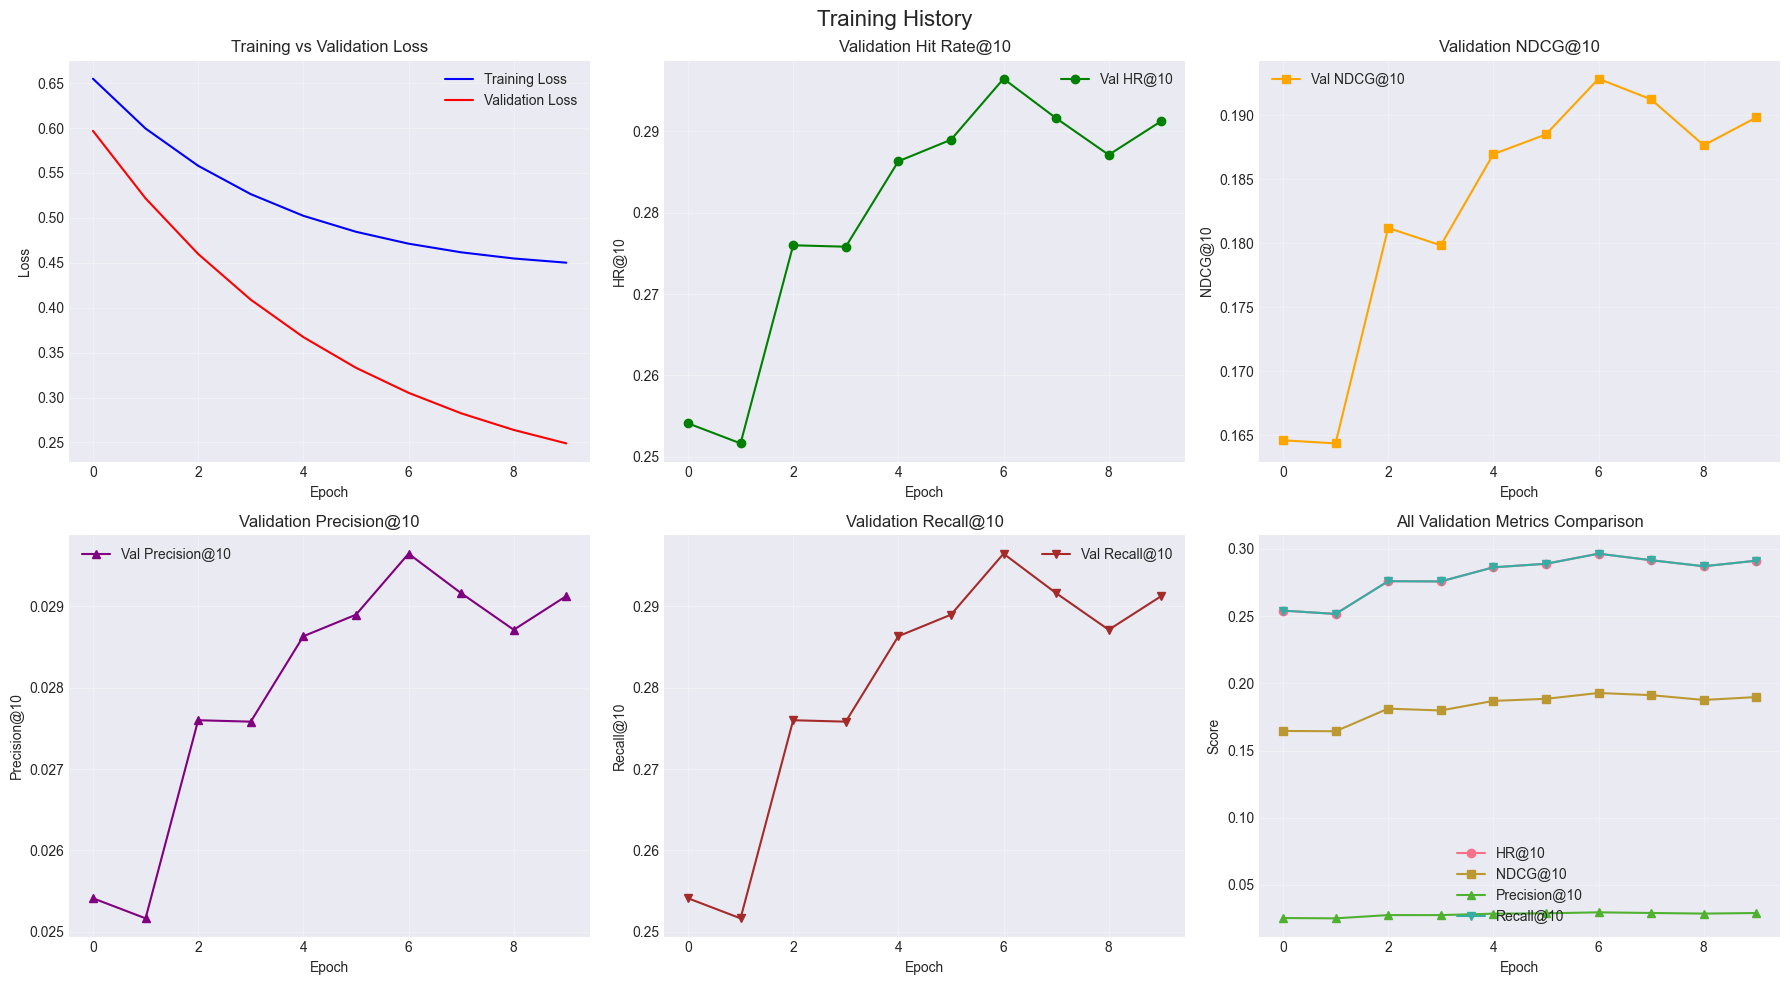


Loading best model for final evaluation on TEST set...

FINAL EVALUATION ON TEST SET

Metrics Results:
------------------------------------------------------------
K     HR         NDCG       Precision    Recall    
------------------------------------------------------------
5     0.2268     0.1736     0.0454       0.2268    
10    0.2943     0.1954     0.0294       0.2943    
20    0.3901     0.2193     0.0195       0.3901    
50    0.6280     0.2660     0.0126       0.6280    
------------------------------------------------------------


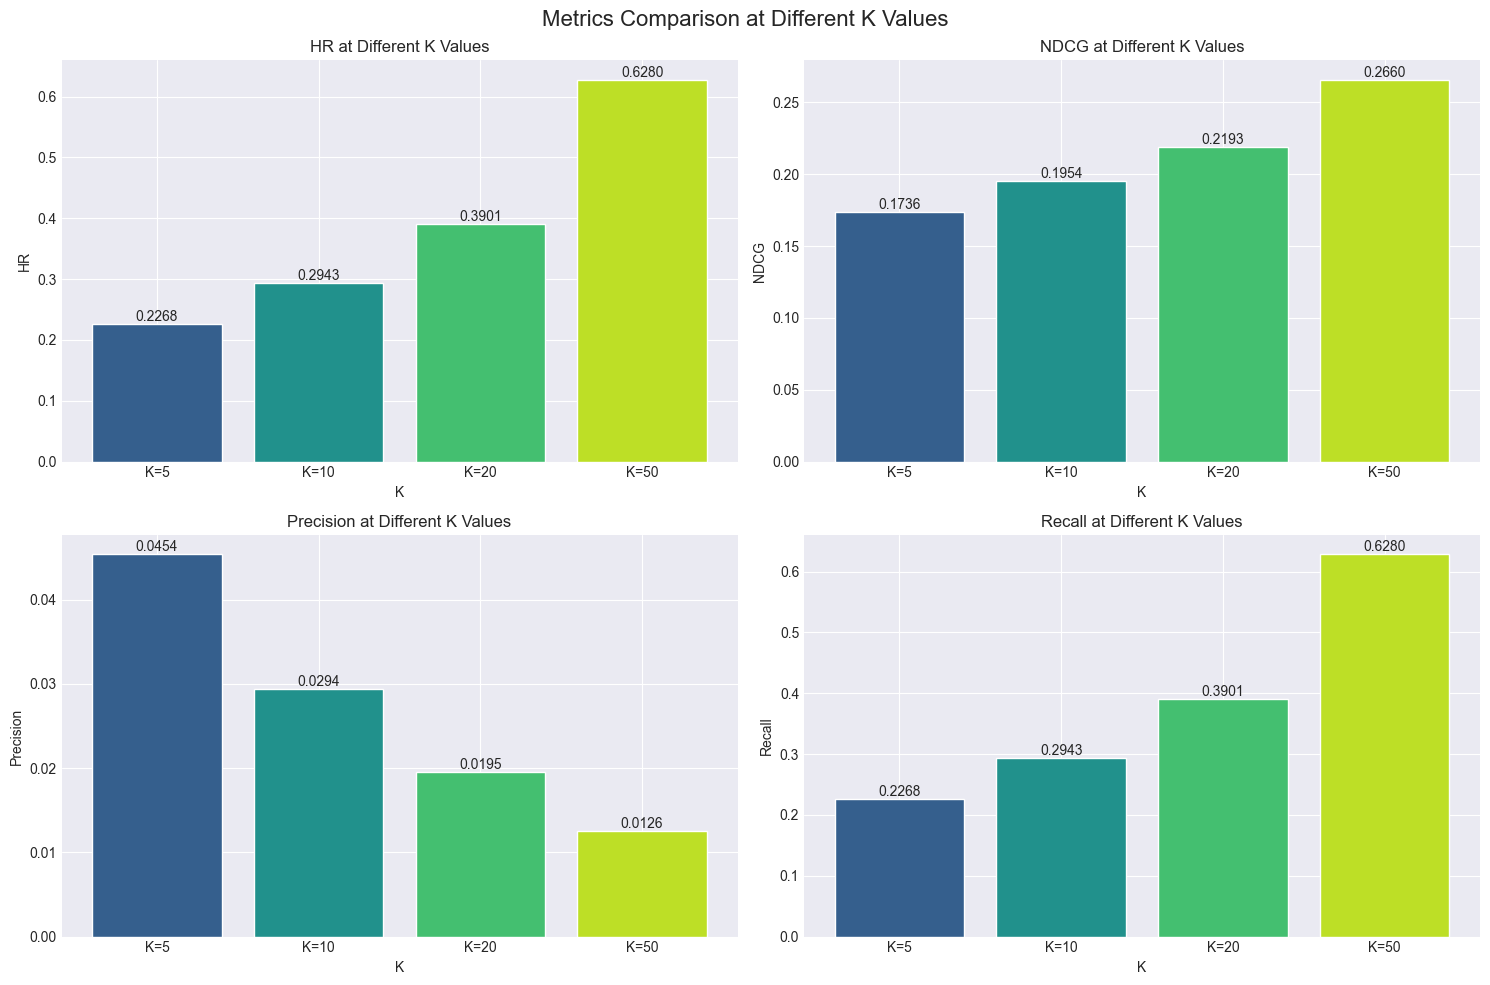


SAMPLE RECOMMENDATIONS

User: AEOJJVQQM5CYJFEJPGBUPJVDUB3A (ID: 10956)
----------------------------------------
Recent interactions:
  - B09M14D9FZ
  - B08TT3V5FJ
  - B09ML1QV1S
  - B08DK7KZQ8

Top 10 Recommendations:
  1. B00I3MQNWG (Score: 0.2780)
  2. B01347V50Y (Score: 0.2769)
  3. B01J4SRJFW (Score: 0.2715)
  4. B00RSGIVVO (Score: 0.2715)
  5. B01AB17IGQ (Score: 0.2713)
  6. B06WVW16WY (Score: 0.2706)
  7. B003AZCYCE (Score: 0.2661)
  8. B007SPQZMC (Score: 0.2659)
  9. B009ZQC7MY (Score: 0.2658)
  10. B004MWZLYC (Score: 0.2653)

User: AGIWHRAMZ6PHAOZN3ZTYUZ72DJOQ (ID: 4684)
----------------------------------------
Recent interactions:
  - B006IVYBGO
  - B00627V8Y2
  - B006IVYBLY
  - B003KIY9P6
  - B000K78Q3Q

Top 10 Recommendations:
  1. B00I3MQNWG (Score: 0.2774)
  2. B01347V50Y (Score: 0.2763)
  3. B01J4SRJFW (Score: 0.2709)
  4. B00RSGIVVO (Score: 0.2709)
  5. B06WVW16WY (Score: 0.2700)
  6. B003AZCYCE (Score: 0.2656)
  7. B007SPQZMC (Score: 0.2653)
  8. B009ZQC7MY (Score: 0.2

In [18]:
# Main execution
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    df = load_amazon_reviews(SOURCE_DOMAIN, max_per_domain=300000)
    print(f"Loaded {len(df)} reviews")

    # Prepare data
    print("\nPreparing data...")
    data = OptimizedNCFData(df, num_neg=4, num_neg_test=99, batch_size=2048)

    # Create data loaders
    train_loader = data.get_train_loader()
    val_loader = data.get_val_loader()  # New validation loader
    test_loader = data.get_test_loader()

    # Model configuration
    embedding_dim = 16
    epochs = 10
    learning_rate = 0.001
    weight_decay=5e-3

    # Create model
    model = ImprovedMatrixFactorization(
        data.n_users,
        data.n_items,
        embedding_dim,
        dropout=0.2
    ).to(DEVICE)

    print(f"\nModel created with {data.n_users} users and {data.n_items} items")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model with comprehensive metrics on validation set
    print("\nStarting training...")
    train_losses, val_losses, val_metrics, best_hr = train_model_with_metrics(
        model, train_loader, val_loader, epochs, DEVICE, learning_rate, weight_decay
    )

    print(f"\nTraining completed! Best Validation HR@10: {best_hr:.4f}")

    # Plot training history with both losses
    plot_training_history(train_losses, val_losses, val_metrics, 'training_history.png')

    # Load best model for final evaluation
    print("\nLoading best model for final evaluation on TEST set...")
    model.load_state_dict(torch.load('best_model.pth'))

    # Final evaluation on test set (unseen data)
    final_metrics = final_evaluation(model, test_loader, DEVICE)

    # Show sample recommendations
    show_sample_recommendations(model, data, num_users=5)

    # Save results to file
    with open('evaluation_results.txt', 'w') as f:
        f.write("FINAL TEST SET EVALUATION RESULTS\n")
        f.write("="*50 + "\n\n")

        f.write(f"Best Validation HR@10: {best_hr:.4f}\n\n")

        f.write("Test Set Metrics:\n")
        f.write("-"*30 + "\n")
        for k in final_metrics.keys():
            f.write(f"K={k}:\n")
            for metric, value in final_metrics[k].items():
                f.write(f"  {metric}: {value:.4f}\n")
            f.write("\n")

    print("\n" + "="*50)
    print("All evaluations completed!")
    print("Results saved to 'evaluation_results.txt'")
    print("Plots saved to 'training_history.png' and 'final_metrics_comparison.png'")
    print("="*50)

    # Clean up
    gc.collect()
    torch.cuda.empty_cache()

In [19]:
import torch
import torch.nn as nn

class NeuralMatrixFactorization(nn.Module):
    """
    Neural Matrix Factorization (NMF) model.

    This model combines Generalized Matrix Factorization (GMF) to learn linear
    interactions and a Multi-Layer Perceptron (MLP) to learn non-linear
    interactions between users and items.
    """
    def __init__(self, n_users, n_items, gmf_embedding_dim, mlp_embedding_dim, mlp_hidden_layers, dropout=0.2):
        """
        Args:
            n_users (int): Number of unique users.
            n_items (int): Number of unique items.
            gmf_embedding_dim (int): Embedding dimension for the GMF path.
            mlp_embedding_dim (int): Embedding dimension for the MLP path.
            mlp_hidden_layers (list of int): A list of hidden layer sizes for the MLP.
                                             Example: [64, 32, 16]
            dropout (float): Dropout rate.
        """
        super().__init__()
        self.n_users = n_users
        self.n_items = n_items
        self.gmf_embedding_dim = gmf_embedding_dim
        self.mlp_embedding_dim = mlp_embedding_dim

        # --- GMF Path ---
        self.gmf_user_embedding = nn.Embedding(n_users, gmf_embedding_dim)
        self.gmf_item_embedding = nn.Embedding(n_items, gmf_embedding_dim)

        # --- MLP Path ---
        self.mlp_user_embedding = nn.Embedding(n_users, mlp_embedding_dim)
        self.mlp_item_embedding = nn.Embedding(n_items, mlp_embedding_dim)

        # Build MLP layers dynamically
        mlp_layers = []
        input_size = 2 * mlp_embedding_dim # Concatenated user and item embeddings
        for size in mlp_hidden_layers:
            mlp_layers.append(nn.Linear(input_size, size))
            mlp_layers.append(nn.ReLU())
            mlp_layers.append(nn.Dropout(dropout))
            input_size = size
        self.mlp = nn.Sequential(*mlp_layers)

        # --- Fusion and Prediction Layer ---
        # The final prediction layer takes the concatenated GMF and MLP outputs
        fusion_input_size = gmf_embedding_dim + mlp_hidden_layers[-1]
        self.predict_layer = nn.Linear(fusion_input_size, 1)

        self._initialize_weights()

    def _initialize_weights(self):
        """Initializes weights using Xavier uniform distribution."""
        nn.init.xavier_uniform_(self.gmf_user_embedding.weight)
        nn.init.xavier_uniform_(self.gmf_item_embedding.weight)
        nn.init.xavier_uniform_(self.mlp_user_embedding.weight)
        nn.init.xavier_uniform_(self.mlp_item_embedding.weight)

        for m in self.mlp.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)

        nn.init.xavier_uniform_(self.predict_layer.weight)
        nn.init.zeros_(self.predict_layer.bias)


    def forward(self, user_ids, item_ids):
        # --- GMF Path ---
        gmf_user_embeds = self.gmf_user_embedding(user_ids)
        gmf_item_embeds = self.gmf_item_embedding(item_ids)
        gmf_vector = gmf_user_embeds * gmf_item_embeds

        # --- MLP Path ---
        mlp_user_embeds = self.mlp_user_embedding(user_ids)
        mlp_item_embeds = self.mlp_item_embedding(item_ids)
        mlp_input = torch.cat([mlp_user_embeds, mlp_item_embeds], dim=1)
        mlp_vector = self.mlp(mlp_input)

        # --- Fusion ---
        fused_vector = torch.cat([gmf_vector, mlp_vector], dim=1)

        # --- Prediction ---
        output = self.predict_layer(fused_vector)

        return torch.sigmoid(output).squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user."""
        device = next(self.parameters()).device
        user_tensor = torch.tensor([user_id], dtype=torch.long, device=device)
        all_item_ids = torch.arange(self.n_items, device=device)

        with torch.no_grad():
            # --- GMF Path ---
            gmf_user_embed = self.gmf_user_embedding(user_tensor)
            gmf_item_embeds = self.gmf_item_embedding(all_item_ids)
            # Element-wise product by broadcasting the user embedding
            gmf_vectors = gmf_user_embed * gmf_item_embeds

            # --- MLP Path ---
            mlp_user_embed = self.mlp_user_embedding(user_tensor)
            # Repeat the user embedding for each item
            mlp_user_embeds_repeated = mlp_user_embed.repeat(self.n_items, 1)
            mlp_item_embeds = self.mlp_item_embedding(all_item_ids)
            mlp_inputs = torch.cat([mlp_user_embeds_repeated, mlp_item_embeds], dim=1)
            mlp_vectors = self.mlp(mlp_inputs)

            # --- Fusion ---
            fused_vectors = torch.cat([gmf_vectors, mlp_vectors], dim=1)

            # --- Prediction ---
            scores = self.predict_layer(fused_vectors)

        return torch.sigmoid(scores).squeeze()

In [21]:
# Main execution
if __name__ == "__main__":
    # Load data
    print("Loading data...")
    df = load_amazon_reviews(SOURCE_DOMAIN, max_per_domain=300000)
    print(f"Loaded {len(df)} reviews")

    # Prepare data
    print("\nPreparing data...")
    data = OptimizedNCFData(df, num_neg=4, num_neg_test=99, batch_size=2048)

    # Create data loaders
    train_loader = data.get_train_loader()
    val_loader = data.get_val_loader()  # New validation loader
    test_loader = data.get_test_loader()

    # Model configuration
    epochs = 10
    learning_rate = 0.001
    weight_decay=5e-3

    # Create model
    model = NeuralMatrixFactorization(
        data.n_users,
        data.n_items,
        gmf_embedding_dim=16,
        mlp_embedding_dim=16,
        mlp_hidden_layers=[32, 16],
        dropout=0.2
    ).to(DEVICE)

    print(f"\nModel created with {data.n_users} users and {data.n_items} items")
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")

    # Train model with comprehensive metrics on validation set
    print("\nStarting training...")
    train_losses, val_losses, val_metrics, best_hr = train_model_with_metrics(
        model, train_loader, val_loader, epochs, DEVICE, learning_rate, weight_decay
    )

    print(f"\nTraining completed! Best Validation HR@10: {best_hr:.4f}")

    # Plot training history with both losses
    plot_training_history(train_losses, val_losses, val_metrics, 'training_history.png')

    # Load best model for final evaluation
    print("\nLoading best model for final evaluation on TEST set...")
    model.load_state_dict(torch.load('best_model.pth'))

    # Final evaluation on test set (unseen data)
    final_metrics = final_evaluation(model, test_loader, DEVICE)

    # Show sample recommendations
    show_sample_recommendations(model, data, num_users=5)

    # Save results to file
    with open('evaluation_results.txt', 'w') as f:
        f.write("FINAL TEST SET EVALUATION RESULTS\n")
        f.write("="*50 + "\n\n")

        f.write(f"Best Validation HR@10: {best_hr:.4f}\n\n")

        f.write("Test Set Metrics:\n")
        f.write("-"*30 + "\n")
        for k in final_metrics.keys():
            f.write(f"K={k}:\n")
            for metric, value in final_metrics[k].items():
                f.write(f"  {metric}: {value:.4f}\n")
            f.write("\n")

    print("\n" + "="*50)
    print("All evaluations completed!")
    print("Results saved to 'evaluation_results.txt'")
    print("Plots saved to 'training_history.png' and 'final_metrics_comparison.png'")
    print("="*50)

    # Clean up
    gc.collect()
    torch.cuda.empty_cache()

Loading data...
Loaded 300000 reviews

Preparing data...
Filtered dataset: 109675 interactions, 13428 users, 12040 items
Split sizes - Train: 83641, Val: 11337, Test: 11337
Common users: 11337

Model created with 13428 users and 12040 items
Model parameters: 816,593

Starting training...


Epoch 1/10: 100%|██████████| 205/205 [01:19<00:00,  2.59it/s, loss=0.464]


Epoch 1: Train Loss=0.5355, Val Loss=0.2055, Val HR@10=0.2501, Val NDCG@10=0.1599, Val Prec@10=0.0250, Val Rec@10=0.2501, Time=165.19s, LR=0.001000
  --> New best model saved with Val HR@10=0.2501


Epoch 2/10: 100%|██████████| 205/205 [01:13<00:00,  2.80it/s, loss=0.445]


Epoch 2: Train Loss=0.4511, Val Loss=0.2054, Val HR@10=0.2356, Val NDCG@10=0.1454, Val Prec@10=0.0236, Val Rec@10=0.2356, Time=157.44s, LR=0.001000


Epoch 3/10: 100%|██████████| 205/205 [01:14<00:00,  2.75it/s, loss=0.45] 


Epoch 3: Train Loss=0.4499, Val Loss=0.2066, Val HR@10=0.2322, Val NDCG@10=0.1414, Val Prec@10=0.0232, Val Rec@10=0.2322, Time=159.27s, LR=0.001000


Epoch 4/10: 100%|██████████| 205/205 [01:13<00:00,  2.80it/s, loss=0.425]


Epoch 4: Train Loss=0.4490, Val Loss=0.2006, Val HR@10=1.0000, Val NDCG@10=0.3754, Val Prec@10=0.1000, Val Rec@10=1.0000, Time=157.50s, LR=0.001000
  --> New best model saved with Val HR@10=1.0000


Epoch 5/10: 100%|██████████| 205/205 [01:13<00:00,  2.81it/s, loss=0.459]


Epoch 5: Train Loss=0.4485, Val Loss=0.2052, Val HR@10=1.0000, Val NDCG@10=0.3562, Val Prec@10=0.1000, Val Rec@10=1.0000, Time=160.49s, LR=0.001000


Epoch 6/10: 100%|██████████| 205/205 [01:14<00:00,  2.74it/s, loss=0.45] 


KeyboardInterrupt: 